**NOTE:** Make sure to run `0_setup_workshop.ipynb` before working on this notebook!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Introduction to Darts
In this notebook, we go over some of the keys functionalities of the library:

* [Basics about the TimeSeries](#Building-and-manipulating-TimeSeries)
* [Training forecasting models and making predictions](#Training-forecasting-models-and-making-predictions)
* [Covariates: using external data](#Covariates:-using-external-data)
* [Probabilistic forecasts](#Probabilistic-forecasts)
* [Backtesting and Residuals](#Backtesting-and-Residuals)

We will only show some minimal "get started" examples here. For more in depth information, you can refer to our [user guide](https://unit8co.github.io/darts/userguide.html) and [example notebooks](https://unit8co.github.io/darts/examples.html).

# Building and manipulating `TimeSeries`
`TimeSeries` is the main data class in Darts. A `TimeSeries` represents a univariate or multivariate time series, with a proper time index. The time index can either be of type `pandas.DatetimeIndex` (containing datetimes), or of type `pandas.RangeIndex` (containing integers; useful for representing sequential data without specific timestamps). `TimeSeries` can also represent *probabilistic* series, which are generated when performing a probabilistic/stochastic forecast. In this case the `TimeSeries` holds multiple samples per time step and column, from which we can obtain confidence intervals, or characteristics of the distribution. 

All models in Darts consume `TimeSeries` and produce `TimeSeries`.

## Read data and build a `TimeSeries`
`TimeSeries` can be built easily using our factory methods `TimeSeries.from_*()` (e.g. from a Pandas `DataFrame` with `TimeSeries.from_dataframe()`, also numpy, csv, ...). You can find all supported methods [here](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries).

Below, we load one of the datasets downloaded at in the workshop setup notebook: Zurich's electricity consumption including weather measurements:

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from darts import TimeSeries

fpath = os.path.join("data", "forecasting", "ewz_stromabgabe_netzebenen_stadt_zuerich_proc.csv")
ts_energy = TimeSeries.from_csv(fpath, time_col="Timestamp")

Technical information about this dataset:

**Frequency**
quarter-hourly (15 Minutes time intervals), but resampled to hourly for the sake of simplicity.

**Target series** (the series we want to forecast):
- **Value_NE5**: Electricity consumption by households on grid level 5 (in kWh).

**Covariates** (external data to help improve forecasts):
The dataset also comes with weather measurements that we can use as covariates. For simplicity, we use:
- **T [°C]**: Measured temperature
- **StrGlo [W/m2]**: Measured solar irradation
- **RainDur [min]**: Measured raining duration

The `TimeSeries` can then easily be manipulated to extract the desired time range and dimensions:

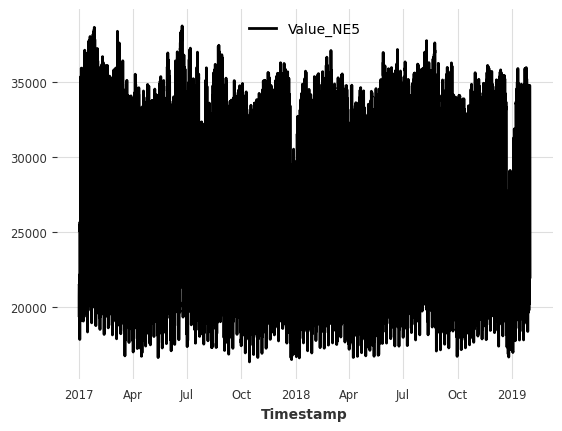

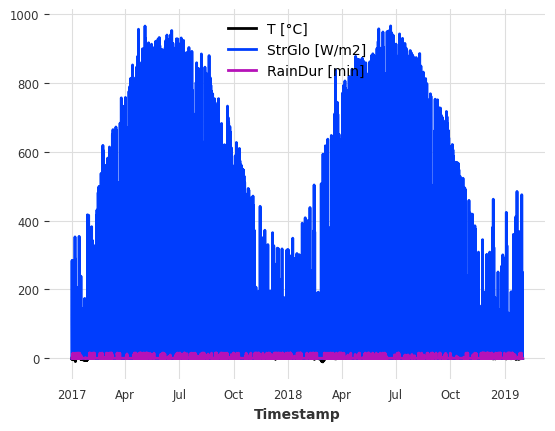

In [3]:
train_start = pd.Timestamp("2017-01-01")
train_end = pd.Timestamp("2018-10-31")
val_end = pd.Timestamp("2018-12-31")
test_end = pd.Timestamp("2019-01-31")

"""
Slice the TimeSeries to extract the values between 01-01-2017 and 13-01-2019

Hint: use `[]` operator (as you would do for list/arrays) or the `slice()` method

Documentation: https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.slice
"""
ts_energy = # your code here

"""
Resample the TimeSeries to an hourly frequency

Hint: use the `TimeSeries.resample()` method to plot the series

Documentation: https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.resample
"""
ts_energy = # your code here

"""
Create a new `TimeSeries` by extracting the following compoments: temperature, solar irradiation and rain duration

Hint: use the `[]` operator and the name of the desired compoments: "T [°C]", "StrGlo [W/m2]", "RainDur [min]"
"""
ts_weather = # your code here

# extract households energy consumption
ts_energy = ts_energy["Value_NE5"]

# create train, validation, and test splits
validation_cutoff = pd.Timestamp("2018-10-31")
ts_energy_train = ts_energy[train_start:train_end]
ts_energy_val = ts_energy[train_end + ts_energy.freq:val_end]
ts_energy_test = ts_energy[val_end + ts_energy.freq:test_end]

"""
Visualize the target and future covariates series in two separate plots

Hint: use the `TimeSeries.plot()` method to plot the series, and plt.show() to plot one figure.

Documentation: https://unit8co.github.io/darts/generated_api/darts.timeseries.html?highlight=plot#darts.timeseries.TimeSeries.plot
"""
# your code here

# Training forecasting models and making predictions

Darts offers a unified API for 40+ different forecasting models. 
- classic statistical models (`ARIMA`, ...)
- regression models for any sklearn-like regression model (also decision treesm gradient boosted methods such as `LightGBM`, `XGBoost`, `CatBoost`, ...)
- state-of-the art neural network/deep learning models such as `TiDE`, `DLinear` or `TSMixer`

For the sake of simplicity, let's focus on Regression Models.

In Darts, the forecasting problem is translated into a regression problem by converting the time series into two tabular arrays:
- `X`: features or input array with the shape (number of samples/observations, number of features)
  - The number of features is given by the total number of (feature specific) target, past, and future covariates lags.
- `y`: target or label array with the shape (number of samples/observations, number of targets)
  - The number of targets is given by the model parameters `output_chunk_length`.

### Target and covariates lags

A lagged feature is the value of a feature at a previous or future time step compared to some reference point. 

In Darts, the value of the lag specifies the position of the feature value relative to the first predicted target time step `y_t0` for each observation/sample (a row in `X`).

- `lag == 0`: position of the first predicted time step `t0`, e.g. position of `y_t0`
- `lag < 0`: all positions in the past of the first predicted time step `t-1`, `t-2`, ...
- `lag > 0`: all positions in the future of the first predicted time step `t+1`, `t+2`, ...

The choice of lags is critical in achieving good predictive accuracy. We want the model to receive relevant information to capture the temporal properties/dependencies our target series (patterns, seasonalities, trends, ...). It also has a considerable impact on the model performance/complexity, as each additional lag adds a new feature to `X`.

At model creation, we can set lags for the target and the covariates series separately.

- `lags`: lags for the target series (the one we want to forecast)
- `lags_past_covariates`: optionally, lags for a past covariates series (external past-observed features to help improve forecasts)
- `lags_future_covariates`: optionally, lags for a future covariates series (external future-known features to help improve forecasts)

There are multiple ways to define your lags `(int, List[int], Tuple[int, int], ...)`. You can find out more about this in the [RegressionModel docs](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html#darts.models.forecasting.regression_model.RegressionModel).

### Lagged data extraction
Now, let's have a look at how `X` and `y` is extracted for training using the scenario from below:

- `lags=[-4,-3,-2,-1]`: use the last 4 target values (green) before the first predicted time step (orange) as `X` features.
- `output_chunk_length=1`: predict the target value `y` of next (`1`) time step (orange).
- we have a target series with 7 time steps `t_i, ..., t_i+6` (blue).

*Note: This example only shows target `lags` extraction, but the same is applied to `lags_past/future_covariates`.*

![forecast_single_model_ocl3](./images/regression_model_train.png)

### Examples
Let's try to apply this to our electricity dataset. Assume, we want to predict the consumption of the next couple of hours after the end of our training set. 

As input features we give it the consumption at the same hour from one and two days ago -> `lags=[-24, -48]`.

<Axes: xlabel='Timestamp'>

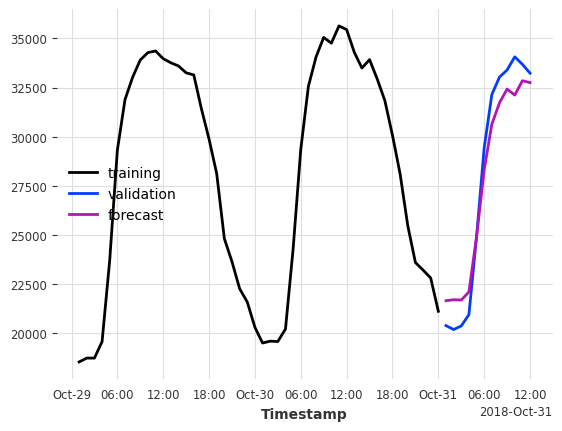

In [4]:
from darts.models import LinearRegressionModel

"""
Create a `LinearRegressionModel`, fit it on the energy series (train split) and forecast 12 values.

Documentation: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html
"""
model = # your code here


ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

And let's also compute the Mean Absolute Percentage Error for this forecast.

The cool thing is that Darts handles the extraction of relevant time frames between the true values and predicted values for us!

So we can give the entire `ts_energy` series without having to worry about that.

In [5]:
from darts.metrics import mape

"""
Compute the mape score between the ground truth and predicted series.

Documentation: https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html?highlight=mape#darts.metrics.metrics.mape
"""
# your code here

# same as with the exact time frames
print("MAPE:", mape(ts_energy[pred.start_time():pred.end_time()], pred))

MAPE: 4.223498841400256
MAPE: 4.223498841400256


### Covariates: using external data

To improve the quality of the forecasts, it is possible to provide external information to the model ; they are called `covariates` in Darts.

![covariates-illustration](./images/covariates-highlevel.png)

To use external data next to the history of our target series, we can pass `past_covariates` and/or `future_covariates` to `fit()` and `predict()`.

For regression models, we have to specify which lags to use from the covariates with `lags_past_covariates`, and `lags_future_covariates`.

Let's assume that instead of having weather measurements, we actually have weather forecasts. Then we could use them as future_covariates. **We only do this here for demonstration purposes!**

Below is an example that uses the last 24 hours (`24`) from hour target series (electricity consumption) and the values at the predicted time step (`[0]`) of our weather "forecasts".

<Axes: xlabel='Timestamp'>

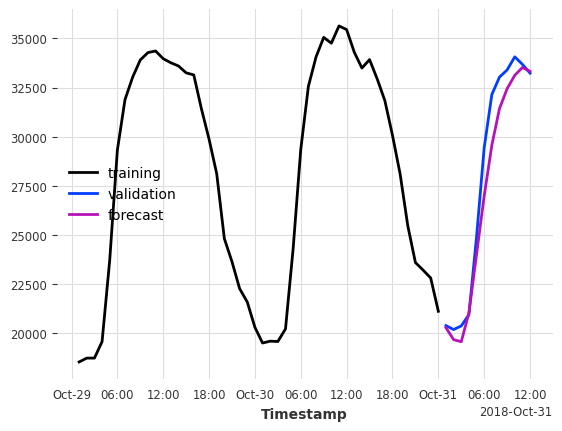

In [6]:
"""
Create a `LinearRegressionModel` with target and future_covariates lags, fit it on the energy series (train split) and the weater covariates.

Documentation: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html
"""
# your code here
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

### Using only covariates as features/predictors

Sometimes, we might also be interested in a forecasting model that purely relies on the covariates values.

To do this, specify at least one of `lags_past_covariates` or `lags_future_covariates` and set `lags=None`. 
Darts regression models are trained in a supervised manner, so we still have to provide the target series for training but it'll not be accessed when calling `predict()`.

How well can we predict the electricity consumption using only the weather "forecasts" and some calendar information (generated for free with `add_encoders`) as input?

The lags tuple `(24, 1)` means (number of lags in the past, number of lags in the future).

<Axes: xlabel='Timestamp'>

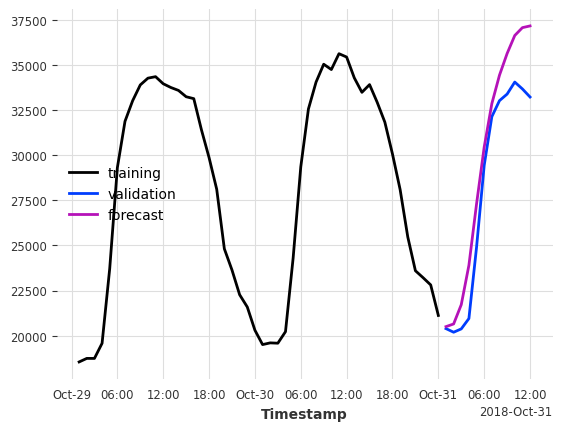

In [7]:
"""
Create a `LinearRegressionModel` that uses encoders to generate future_covariates based on the "hour", "month" and "dayofweek" components of
the series' time index.

Hint: Make sure to use the cyclic representation

Documentation: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html, see code example 
for the `add_encoders` argument
"""

model = # your code here
model.fit(series=ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

### Model's output chunk length

This key parameter sets the *number of time steps that can be predicted at once by the internal regression or neural network model*.

It is not the same as forecast horizon `n` from `model.predict()` which is the **desired** the number of generated prediction points, that is achieved either with:
- a single shot forecast (if `n <= output_chunk_length`), or
- an auto-regressive forecast, consuming its own forecast (and future values of covariates) as input for additional predictions (otherwise)

For example, if we want our model to forecast the next 24 hours of electricity consumption based on the last day of consumption, setting `output_chunk_length=24` ensures that the model will not consume its forecasts or future values of our covariates to predict the entire day.

<Axes: xlabel='Timestamp'>

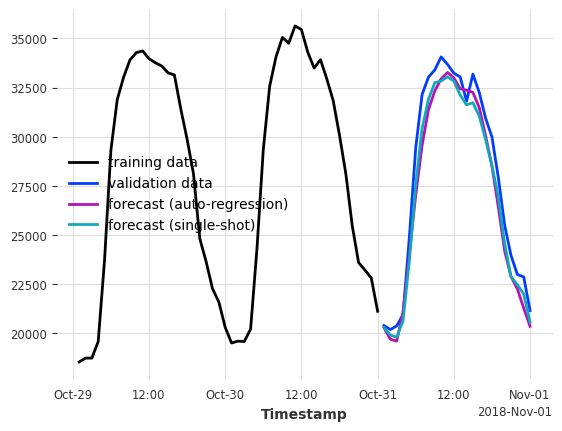

In [8]:
model_auto_regression = LinearRegressionModel(lags=24, output_chunk_length=1)
model_single_shot = LinearRegressionModel(lags=24, output_chunk_length=24)

model_auto_regression.fit(ts_energy_train)
model_single_shot.fit(ts_energy_train)

pred_auto_regression = model_auto_regression.predict(24)
pred_single_shot = model_single_shot.predict(24)

ts_energy_train[-48:].plot(label="training data")
ts_energy_val[:24].plot(label="validation data")
pred_auto_regression.plot(label="forecast (auto-regression)")
pred_single_shot.plot(label="forecast (single-shot)")

### Gradient Boosted Models and Validations Sets

With the gradient boosted models (`LightGBMModel`, `XGBoostModel`, and `CatBoostModel`), you can pass a validation set to `model.fit()` to reduce overfitting.
You simply have to supply `val_series` (and `val_past_covariates`, `val_future_covariates` if you use covariates).

Since we use the validation set for early stopping, we should not evaluate the model on this set. So, let's generate the forecasts this time on the test set.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27345
[LightGBM] [Info] Number of data points in the train set: 16009, number of used features: 249
[LightGBM] [Info] Start training from score 25959.343092


<Axes: xlabel='Timestamp'>

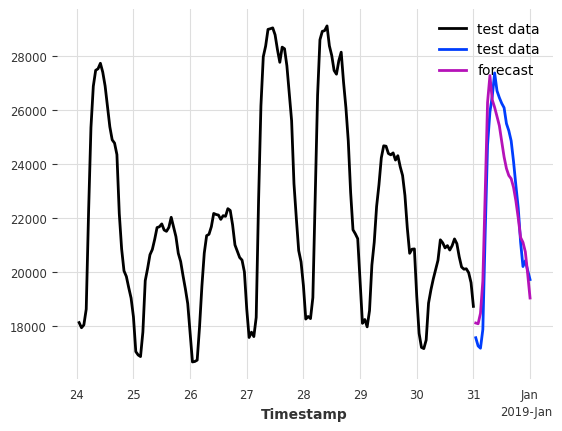

In [9]:
from darts.models import LightGBMModel

model = LightGBMModel(
    lags=24, 
    lags_future_covariates=(24, 1),
    add_encoders={"cyclic": {"future": ["hour", "month", "dayofweek"]}},
    output_chunk_length=1
)

"""
Fit the LightGBMModel using validation series (target and covariates)

Documentation: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.lgbm.html
"""

model.fit(
    # your code here
)

preds_test = model.predict(24, series=ts_energy_val, future_covariates=ts_weather)

ts_energy_val[-7*24:].plot(label="test data")
ts_energy_test[:24].plot(label="test data")
preds_test.plot(label="forecast")

### Probabilistic forecasting

To make a model probablistic, set parameter `likelihood` to `quantile` or `poisson` when creating a `RegressionModel`. At prediction time, probabilistic models can either :
- use Monte Carlo sampling to generate samples based on the fitted distribution parameters (or quantiles) when `num_samples > 1`
- return the fitted distribution parameters (or quantiles) directly when `predict_likelihood_parameters=True`

Note that when using the `quantile` regressor, each quantile will be fitted by a different model.

Probabilistic models will generate different forecasts each time `predict()` is called with `num_samples > 1`. To get reproducible results, set the random seed when creating the model and call the methods in the exact same order.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 16009, number of used features: 24
[LightGBM] [Info] Start training from score 19369.455078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 16009, number of used features: 24
[LightGBM] [Info] Start training from score 24040.804688
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the t

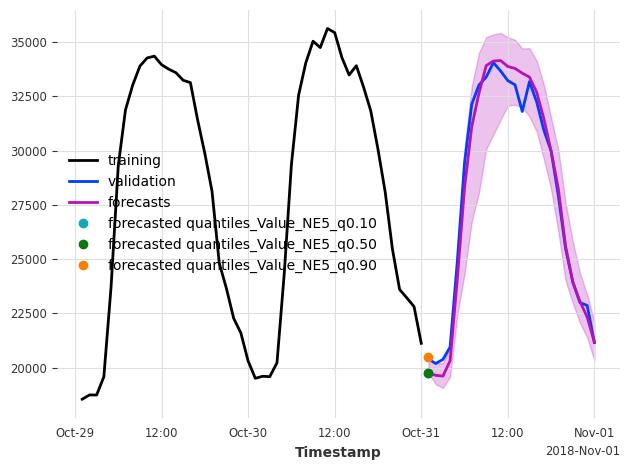

In [10]:
"""
Create a probabilistic `LightGBMModel` with lags=24, output_chunk_length=1 and quantiles=[0.1, 0.5, 0.9].

Hint: don't forget to specify the likelihood!

Documentation: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.lgbm
"""
model = LightGBMModel(
    # your code here
)

model.fit(ts_energy_train)

"""
Use the probabilistic model to predict 25 steps, with 200 samples

Documentation: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.lgbm
"""
pred_samples = # your code here
pred_params = model.predict(n=1, predict_likelihood_parameters=True)

for val, comp in zip(pred_params.values()[0], pred_params.components):
    print(f"{comp} : {round(val, 3)}")

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_samples.plot(label="forecasts")
pred_params.plot(label="forecasted quantiles")
plt.tight_layout()

## Backtesting and Residuals

So at this point, we know how to use a model to generate single forecasts and evaluate them. This is great but not enough. Better would be to know how the model would have performed over time, if used historically.

For this we can use Darts historical forecast, backtest, and residuals support. These methods are comparable to cross-validation for tabular data.

#### Historical Forecasts (`model.historical_forecasts()`): 
- compute forecasts with a moving forecasting (reference) point over the history of a time series.
- For **classic models** (`ARIMA`, ...) the model needs to be **retrained** at each step. It uses the past of the moving forecasting point for training. This can take quite a while to compute.
- For our **regression** and **neural network models**, you can also use a **pre-trained** model to generate all forecasts directly. **This is really fast!**

![covariates-illustration](./images/historical_forecasts.png)


#### Backtesting (`model.backtest()`):
- computes one or multiple metrics for each historical forecast
- by default it will give the Mean Absolute Percentage Error (MAPE) aggregated per forecast
- you can use any of Darts' [aggregated metrics](https://unit8co.github.io/darts/generated_api/darts.metrics.html#metrics).

![covariates-illustration](./images/backtest.png)


#### Residuals (`model.residuals()`):
- computes a metric value for each historical forecast and predicted time.
- by default it computes the deviation between the forecasts and actual values
- you can use any of Darts' [*per-time-step* metrics](https://unit8co.github.io/darts/generated_api/darts.metrics.html#metrics).


In the example below, we simulate forecasts with 24 hours horizon. By default (with `last_points_only=True`) it will return a single `TimeSeries` containing only the last predicted point per forecast.
If `last_points_only=False`, it would give a list of forecasts, each covering the entire 24 hour horizon.

In [11]:
"""
Generate historical forecasts for the model_single_shot using the `historical_forecasts()` method

Hint: it should start after the end of the train split, use an horizon of 24, not retrain the model & keep only the last point of each forecast

Documentation: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html?highlight=linearregressionmodel#darts.models.forecasting.linear_regression_model.LinearRegressionModel.historical_forecasts
"""
hf_single = model_single_shot.historical_forecasts(
    # your code here
)

  0%|          | 0/1 [00:00<?, ?it/s]

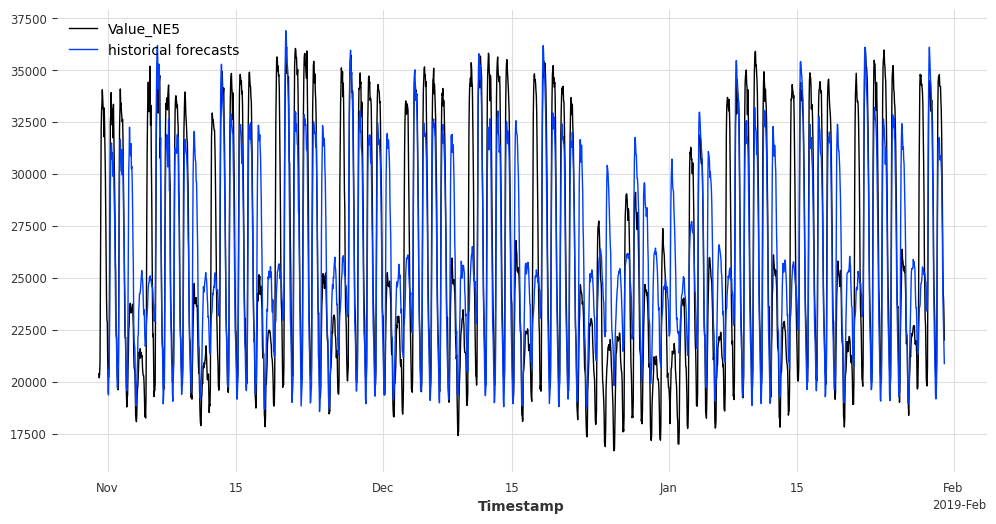

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
ts_energy[train_end + ts_energy.freq:].plot(lw=1)
hf_single.plot(lw=1, label="historical forecasts")
plt.show()

In [13]:
# And the backtest for these forecasts
backtest_single = model_single_shot.backtest(
    ts_energy, 
    historical_forecasts=hf_single,
    metric=mape,
    last_points_only=True
)
print(f"Obtained a mape of {backtest_single} over the historical forecasts.")

Obtained a mape of 10.351772163838236 over the historical forecasts.


Now, let’s look at residuals/deviation of each predicted value compared to the actual values:

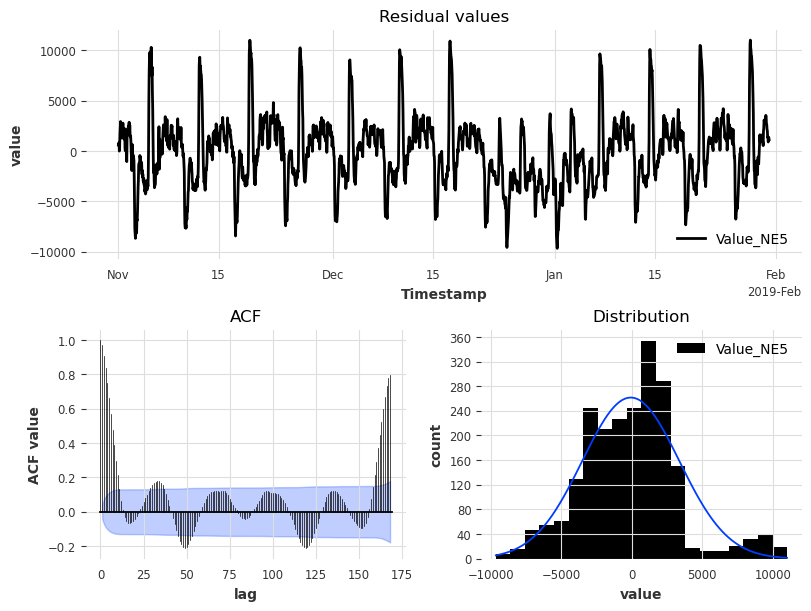

In [14]:
from darts.utils.statistics import plot_residuals_analysis

"""
Compute the residuals using the `residuals()` method

Hint: you can reuse the historical forecasts generated above (`hf_single`) to save time!

Documentation: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html?highlight=linearregressionmodel#darts.models.forecasting.linear_regression_model.LinearRegressionModel.residuals
"""
residuals = # your code here

# visualize some stats
plot_residuals_analysis(residuals, acf_max_lag=7*24)

For a robust model, we would expect:
- Residual values over time should show constant variance and mean=0
- Residuals ACF should not show signs of auto-correlation with past lags (e.g. the ACF values are randomly scattered on the plot, without ramps or sinusoidal patterns)
- The residuals destribution should be similar to a gaussian with mean 0

We see that our model doesn't really perform that well:
- residuals over time show temporal patterns, varying variance over time
- ACF shows very strong correlation with the residuals from the most recent past, and residuals from a week ago (lag=24*7=168)
- ...

## Conclusion

- Darts offers a simple data-structure, the `TimeSeries`, to provide a lot of features as well as safeguards for ingestion and manipulation of timeseries.
- Through a unified API across libraries (classic models, regression model, and neural networks) Darts makes it very east to experiment with a large variety of models and obtain forecasts in just a few lines of codes
- By tabularizing the data, Darts closes the gap between traditional regression problems and timeseries forecasting
- With Darts' metrics, historical forecasts, backtest, and residuals support, we have all the tools requried to properly evaluate a model and assess it's performance over time time